###Author: William C Francis

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading in the dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


####Defining the model

In [ ]:
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

###Part (a) : Finding optimal learning rate

In [ ]:
#Defining the hyperparameters
model = allcnn_t().to(device)
epochs = 2
startlr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=startlr, momentum=0.9, weight_decay=1e-3, nesterov=True)

train_loss_batch = []
lr_batch = []

model = model.to(device)
total_step = len(trainloader)
overall_step = 0
for epoch in range(epochs):
    count1 = 0
    count2 = 0
    correct = 0
    total = 0
    train_loss=0
    test_loss=0
    model.train()

    for i, (images, labels) in enumerate(trainloader):
        # Move tensors to configured device
        images = images.to(device)
        labels = labels.to(device)
        #Forward Pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        optimizer.param_groups[0]['lr'] *= 1.02 #incrementing by a lower value to get a higher resolution in the loss curve
        if(len(train_loss_batch) < 600): # Storing first 600 values of loss
          train_loss_batch.append(loss.item())
          lr_batch.append(optimizer.param_groups[0]['lr'])

Num parameters:  1667166


####Plotting the Loss vs Learning rate

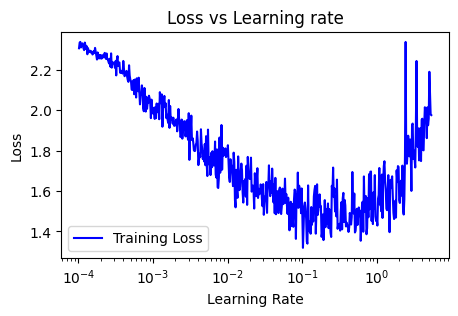

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(lr_batch[:550], train_loss_batch[:550], 'b', label='Training Loss')
plt.xscale('log') 
plt.title('Loss vs Learning rate')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.legend()
    

####Finding Global minimum for optimum learning rate

In [ ]:
optim_lr = lr_batch[np.argmin(train_loss_batch[:550])]
print(optim_lr)

0.10234346501391212


####Part (c) : Implementing Cosine LR Scheduling with a warm up

In [ ]:
model = allcnn_t().to(device)
epochs = 100
T = epochs * 391
T_0 = T/5
max_lr = optim_lr/10
start_lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=startlr, momentum=0.9, weight_decay=1e-3, nesterov=True)

train_loss_tot = []
train_acc_tot = []
test_loss_tot = []
test_acc_tot = []
train_loss_batch = []
wu_lr = []
n_wu = []
wu_loss = []
wu_err = []
model = model.to(device)
total_step = len(trainloader)
overall_step = 0
t=0
for epoch in range(epochs):
    count1 = 0
    count2 = 0
    correct = 0
    total = 0
    train_loss=0
    test_loss=0
    model.train()

    for i, (images, labels) in enumerate(trainloader):
        t+=1
        wu_lr.append(optimizer.param_groups[0]['lr'])
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(t < T_0):
          optimizer.param_groups[0]['lr'] = 1e-4 + (t / T_0) * max_lr #Linear warm up
        else:
          optimizer.param_groups[0]['lr'] = max_lr * np.cos((np.pi/2)*((t-T_0)/(T-T_0))) + 1e-6 #Cosine annealing
        train_loss += loss.item()
        wu_loss.append(loss.item())
        n_wu.append(t)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        count1+=1
        wu_err.append(100 - (100*predicted.eq(labels).sum().item()/labels.size(0))) #Training error per weight update

    train_loss = train_loss/count1
    train_acc = 100*correct/total
    train_loss_tot = np.append(train_loss_tot, train_loss)
    train_acc_tot = np.append(train_acc_tot, train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            count2+=1

    test_loss = test_loss/count2
    test_acc = 100*correct/total
    test_loss_tot = np.append(test_loss_tot, test_loss)
    test_acc_tot = np.append(test_acc_tot, test_acc)
    print("Epoch",epoch+1,"/",epochs,"| Train Loss:", round(train_loss, 4), "| Train Accuracy:", train_acc, "|| Test Loss:", round(test_loss,4), "| Test Accuracy:", test_acc)
    print("Learning rate: ",optimizer.param_groups[0]['lr'])

Num parameters:  1667166
Epoch 1 / 100 | Train Loss: 2.0469 | Train Accuracy: 25.064 || Test Loss: 2.1615 | Test Accuracy: 23.55
Learning rate:  0.0006117173250695607
Epoch 2 / 100 | Train Loss: 1.733 | Train Accuracy: 39.318 || Test Loss: 1.8734 | Test Accuracy: 32.35
Learning rate:  0.0011234346501391213
Epoch 3 / 100 | Train Loss: 1.532 | Train Accuracy: 47.606 || Test Loss: 1.7294 | Test Accuracy: 37.71
Learning rate:  0.0016351519752086817
Epoch 4 / 100 | Train Loss: 1.3756 | Train Accuracy: 53.05 || Test Loss: 1.6591 | Test Accuracy: 42.89
Learning rate:  0.0021468693002782424
Epoch 5 / 100 | Train Loss: 1.2366 | Train Accuracy: 57.898 || Test Loss: 1.3821 | Test Accuracy: 51.71
Learning rate:  0.0026585866253478027
Epoch 6 / 100 | Train Loss: 1.1213 | Train Accuracy: 62.008 || Test Loss: 1.2121 | Test Accuracy: 57.43
Learning rate:  0.003170303950417363
Epoch 7 / 100 | Train Loss: 1.0319 | Train Accuracy: 64.686 || Test Loss: 1.0439 | Test Accuracy: 64.35
Learning rate:  0.00368

####Plotting the Training loss, Training error and Learning rate as a function of the number of weight updates

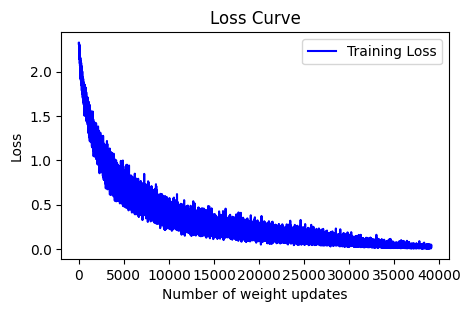

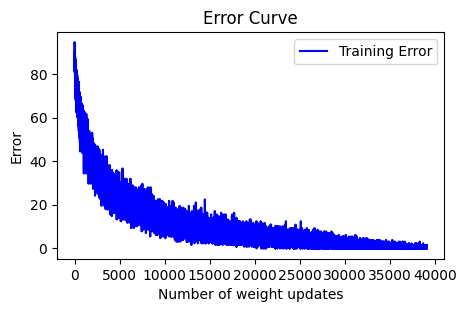

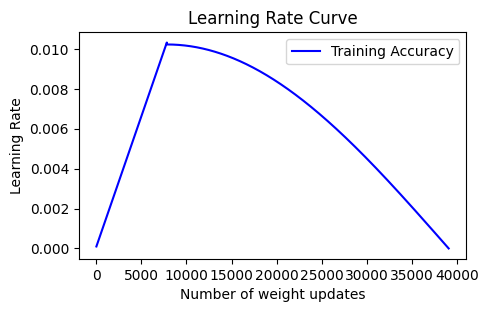

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, wu_loss, 'b', label='Training Loss')
plt.title('Loss Curve')
plt.xlabel('Number of weight updates')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, wu_err, 'b', label='Training Error')
plt.title('Error Curve')
plt.xlabel('Number of weight updates')
plt.ylabel('Error')
plt.legend()

plt.figure(figsize=(5,3), dpi=100)
plt.plot(n_wu, wu_lr, 'b', label='Training Accuracy')
plt.title('Learning Rate Curve')
plt.xlabel('Number of weight updates')
plt.ylabel('Learning Rate')
plt.legend()

#### Plotting the Training & Validation Loss and Training & Validation accuracy as a function of the number of epochs

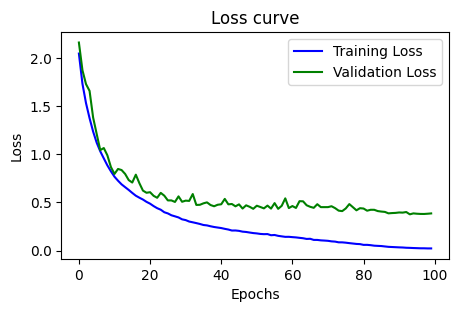

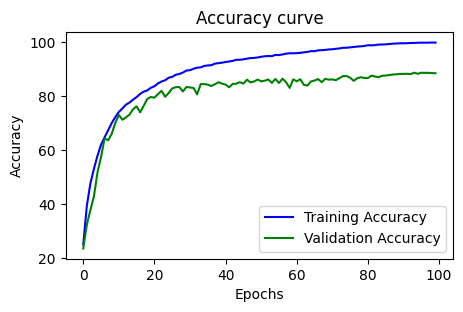

In [ ]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(np.arange(epochs), train_loss_tot, 'b', label='Training Loss')
plt.title('Loss curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(np.arange(epochs), test_loss_tot, 'g', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure(figsize=(5,3), dpi=100)
plt.plot(np.arange(epochs), train_acc_tot, 'b', label='Training Accuracy')
plt.title('Accuracy curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.plot(np.arange(epochs), test_acc_tot, 'g', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


### Part (d)

####(i) Training with ηmax and ρ = 0.9

In [ ]:
#Defining the hyperparameters
model = allcnn_t().to(device)
epochs = 50
T = epochs * 391
T_0 = T/5
max_lr = optim_lr/10
start_lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=startlr, momentum=0.9, weight_decay=1e-3, nesterov=True)

train_loss_tot = []
train_acc_tot = []
test_loss_tot = []
test_acc_tot = []
train_loss_batch = []
all_lr = []
n_wu = []

model = model.to(device)
total_step = len(trainloader)
overall_step = 0
t=0
for epoch in range(epochs):
    count1 = 0
    count2 = 0
    correct = 0
    total = 0
    train_loss=0
    test_loss=0
    model.train()

    for i, (images, labels) in enumerate(trainloader):
        t+=1
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(t < T_0):
          optimizer.param_groups[0]['lr'] = 1e-4 + (t / T_0) * max_lr
        else:
          optimizer.param_groups[0]['lr'] = max_lr * np.cos((np.pi/2) * ((t-T_0)/(T-T_0))) + 1e-6
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        count1+=1

    all_lr.append(optimizer.param_groups[0]['lr'])
    n_wu.append(t)
    train_loss = train_loss/count1
    train_acc = 100*correct/total
    train_loss_tot = np.append(train_loss_tot, train_loss)
    train_acc_tot = np.append(train_acc_tot, train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            count2+=1

    test_loss = test_loss/count2
    test_acc = 100*correct/total
    test_loss_tot = np.append(test_loss_tot, test_loss)
    test_acc_tot = np.append(test_acc_tot, test_acc)
    print("Epoch (",epoch+1,"/",epochs,") | Train Loss:", round(train_loss, 4), "| Train Accuracy:", train_acc, "|| Test Loss:", round(test_loss,4), "| Test Accuracy:", test_acc)


Num parameters:  1667166
Epoch ( 1 / 50 ) | Train Loss: 1.9812 | Train Accuracy: 28.164 || Test Loss: 2.1957 | Test Accuracy: 23.95
Epoch ( 2 / 50 ) | Train Loss: 1.6335 | Train Accuracy: 43.356 || Test Loss: 1.7652 | Test Accuracy: 37.87
Epoch ( 3 / 50 ) | Train Loss: 1.4019 | Train Accuracy: 52.286 || Test Loss: 1.6838 | Test Accuracy: 42.55
Epoch ( 4 / 50 ) | Train Loss: 1.217 | Train Accuracy: 58.596 || Test Loss: 1.3783 | Test Accuracy: 50.91
Epoch ( 5 / 50 ) | Train Loss: 1.0899 | Train Accuracy: 62.544 || Test Loss: 1.1995 | Test Accuracy: 57.91
Epoch ( 6 / 50 ) | Train Loss: 0.9837 | Train Accuracy: 66.348 || Test Loss: 1.1367 | Test Accuracy: 60.65
Epoch ( 7 / 50 ) | Train Loss: 0.9007 | Train Accuracy: 69.188 || Test Loss: 0.9687 | Test Accuracy: 66.69
Epoch ( 8 / 50 ) | Train Loss: 0.825 | Train Accuracy: 71.95 || Test Loss: 0.958 | Test Accuracy: 67.43
Epoch ( 9 / 50 ) | Train Loss: 0.7614 | Train Accuracy: 74.19 || Test Loss: 0.7931 | Test Accuracy: 73.35
Epoch ( 10 / 50 )

Validation error = 12.56%

####(ii) Training with ηmax ← 5ηmax and ρ = 0.5

In [ ]:
model = allcnn_t().to(device)
epochs = 50
T = epochs * 391
T_0 = T/5
max_lr = optim_lr/10
max_lr *= 5
start_lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.5, weight_decay=1e-3, nesterov=True)

train_loss_tot = []
train_acc_tot = []
test_loss_tot = []
test_acc_tot = []
train_loss_batch = []
all_lr = []
n_wu = []

model = model.to(device)
total_step = len(trainloader)
overall_step = 0
t=0
for epoch in range(epochs):
    count1 = 0
    count2 = 0
    correct = 0
    total = 0
    train_loss=0
    test_loss=0
    model.train()

    for i, (images, labels) in enumerate(trainloader):
        t+=1
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(t < T_0):
          optimizer.param_groups[0]['lr'] = 1e-4 + (t / T_0) * max_lr
        else:
          optimizer.param_groups[0]['lr'] = max_lr * np.cos((np.pi/2) * ((t-T_0)/(T-T_0))) + 1e-6
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        count1+=1

    all_lr.append(optimizer.param_groups[0]['lr'])
    n_wu.append(t)
    train_loss = train_loss/count1
    train_acc = 100*correct/total
    train_loss_tot = np.append(train_loss_tot, train_loss)
    train_acc_tot = np.append(train_acc_tot, train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            count2+=1

    test_loss = test_loss/count2
    test_acc = 100*correct/total
    test_loss_tot = np.append(test_loss_tot, test_loss)
    test_acc_tot = np.append(test_acc_tot, test_acc)
    print("Epoch (",epoch+1,"/",epochs,") | Train Loss:", round(train_loss, 4), "| Train Accuracy:", train_acc, "|| Test Loss:", round(test_loss,4), "| Test Accuracy:", test_acc)


Num parameters:  1667166
Epoch ( 1 / 50 ) | Train Loss: 2.0237 | Train Accuracy: 26.59 || Test Loss: 2.1866 | Test Accuracy: 23.22
Epoch ( 2 / 50 ) | Train Loss: 1.6449 | Train Accuracy: 43.02 || Test Loss: 1.7759 | Test Accuracy: 36.3
Epoch ( 3 / 50 ) | Train Loss: 1.4243 | Train Accuracy: 51.114 || Test Loss: 1.5332 | Test Accuracy: 45.53
Epoch ( 4 / 50 ) | Train Loss: 1.2442 | Train Accuracy: 57.552 || Test Loss: 1.2541 | Test Accuracy: 55.71
Epoch ( 5 / 50 ) | Train Loss: 1.1105 | Train Accuracy: 61.918 || Test Loss: 1.1463 | Test Accuracy: 59.54
Epoch ( 6 / 50 ) | Train Loss: 1.0152 | Train Accuracy: 64.862 || Test Loss: 1.0759 | Test Accuracy: 62.33
Epoch ( 7 / 50 ) | Train Loss: 0.9255 | Train Accuracy: 68.302 || Test Loss: 1.047 | Test Accuracy: 64.65
Epoch ( 8 / 50 ) | Train Loss: 0.8482 | Train Accuracy: 71.13 || Test Loss: 0.8547 | Test Accuracy: 70.5
Epoch ( 9 / 50 ) | Train Loss: 0.7865 | Train Accuracy: 73.07 || Test Loss: 1.0394 | Test Accuracy: 65.37
Epoch ( 10 / 50 ) |

Validation error = 12.76%

It can be observed that after training the network for 50 epochs, the first two settings, ηmax & ρ = 0.9 and ηmax ← 5ηmax and ρ = 0.5 resulted in a validation error of 12.56% and 12.76% respectively. These are about the same because we keep the ηmax/(1−ρ) constant.

#### (iii) Training with ηmax ← ηmax and ρ = 0.5

In [ ]:
#Defining the hyperparameters
model = allcnn_t().to(device)
epochs = 50
T = epochs * 391
T_0 = T/5
max_lr = optim_lr/10
start_lr = 1e-4
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=start_lr, momentum=0.5, weight_decay=1e-3, nesterov=True)

train_loss_tot = []
train_acc_tot = []
test_loss_tot = []
test_acc_tot = []
train_loss_batch = []
all_lr = []
n_wu = []

model = model.to(device)
total_step = len(trainloader)
overall_step = 0
t=0
for epoch in range(epochs):
    count1 = 0
    count2 = 0
    correct = 0
    total = 0
    train_loss=0
    test_loss=0
    model.train()

    for i, (images, labels) in enumerate(trainloader):
        t+=1
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(t < T_0):
          optimizer.param_groups[0]['lr'] = 1e-4 + (t / T_0) * max_lr
        else:
          optimizer.param_groups[0]['lr'] = max_lr * np.cos((np.pi/2) * ((t-T_0)/(T-T_0))) + 1e-6
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        count1+=1

    all_lr.append(optimizer.param_groups[0]['lr'])
    n_wu.append(t)
    train_loss = train_loss/count1
    train_acc = 100*correct/total
    train_loss_tot = np.append(train_loss_tot, train_loss)
    train_acc_tot = np.append(train_acc_tot, train_acc)

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for i, (images, labels) in enumerate(testloader):
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            test_loss += loss.item()
            count2+=1

    test_loss = test_loss/count2
    test_acc = 100*correct/total
    test_loss_tot = np.append(test_loss_tot, test_loss)
    test_acc_tot = np.append(test_acc_tot, test_acc)
    print("Epoch (",epoch+1,"/",epochs,") | Train Loss:", round(train_loss, 4), "| Train Accuracy:", train_acc, "|| Test Loss:", round(test_loss,4), "| Test Accuracy:", test_acc)


Num parameters:  1667166
Epoch ( 1 / 50 ) | Train Loss: 2.1541 | Train Accuracy: 20.216 || Test Loss: 2.3652 | Test Accuracy: 17.19
Epoch ( 2 / 50 ) | Train Loss: 1.8882 | Train Accuracy: 32.184 || Test Loss: 2.1936 | Test Accuracy: 23.11
Epoch ( 3 / 50 ) | Train Loss: 1.7285 | Train Accuracy: 39.394 || Test Loss: 1.9743 | Test Accuracy: 29.77
Epoch ( 4 / 50 ) | Train Loss: 1.6011 | Train Accuracy: 44.988 || Test Loss: 1.8479 | Test Accuracy: 34.37
Epoch ( 5 / 50 ) | Train Loss: 1.4835 | Train Accuracy: 49.634 || Test Loss: 1.6481 | Test Accuracy: 40.88
Epoch ( 6 / 50 ) | Train Loss: 1.3751 | Train Accuracy: 53.676 || Test Loss: 1.5926 | Test Accuracy: 43.12
Epoch ( 7 / 50 ) | Train Loss: 1.2794 | Train Accuracy: 56.93 || Test Loss: 1.6169 | Test Accuracy: 45.02
Epoch ( 8 / 50 ) | Train Loss: 1.195 | Train Accuracy: 59.54 || Test Loss: 1.412 | Test Accuracy: 50.59
Epoch ( 9 / 50 ) | Train Loss: 1.1177 | Train Accuracy: 62.156 || Test Loss: 1.2797 | Test Accuracy: 55.81
Epoch ( 10 / 50 

Validation error = 18.99%

It can be observed that when we set ηmax ← ηmax and ρ = 0.5, the training error increases to 18.99% from ~12.6%